# Практична робота №2: Логістична регресія з нуля

## Завдання
- Реалізувати логістичну регресію з нуля для класифікації результатів медичних тестів.
- Реалізувати оптимізацію: SGD і mini-batch.
- Дослідити вплив регуляризації (L1/L2).
- Оцінити якість моделі (confusion matrix, Accuracy, Precision, Recall, F1).
- Побудувати криві навчання.
- Зробити висновки.

In [179]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Налаштування відображення
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [180]:
def load_and_analyze_data():
    # Завантаження даних
    df = pd.read_csv('synthetic_coffee_health_10000.csv')
    
    print("=== Інформація про датасет ===")
    print(f"Розмір датасету: {df.shape}")
    print(f"Колонки: {df.columns.tolist()}")
    print("\nПерші 5 рядків:")
    print(df.head())
    
    print("\n=== Інформація про типи даних ===")
    print(df.info())
    
    print("\n=== Статистичний опис ===")
    print(df.describe())
    
    return df

# Виконання функції
df = load_and_analyze_data()

=== Інформація про датасет ===
Розмір датасету: (10000, 16)
Колонки: ['ID', 'Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption']

Перші 5 рядків:
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7       

### Завантаження даних та підготовка даних

In [181]:
def prepare_data(df):
    # Створення бінарної цільової змінної
    df['Health_Issues_Binary'] = (df['Health_Issues'].isin(['Moderate', 'Severe'])).astype(int)
    
    # Видалення непотрібних колонок
    columns_to_drop = ['ID', 'Sleep_Quality', 'Stress_Level', 'Health_Issues']
    df_clean = df.drop(columns=columns_to_drop)
    
    # Кодування категоріальних змінних
    categorical_columns = ['Gender', 'Country', 'Occupation']
    df_encoded = pd.get_dummies(df_clean, columns=categorical_columns, drop_first=True)
    
    # Кодування булевих змінних
    bool_columns = ['Smoking', 'Alcohol_Consumption']
    for col in bool_columns:
        df_encoded[col] = df_encoded[col].astype(int)
    
    # Нормалізація числових ознак
    numerical_columns = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 
                        'Heart_Rate', 'Physical_Activity_Hours']
    
    scaler = StandardScaler()
    df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])
    
    print(f"Розмір датасету після підготовки: {df_encoded.shape}")
    print(f"Розподіл цільової змінної:\n{df_encoded['Health_Issues_Binary'].value_counts()}")
    
    return df_encoded, scaler

# Виконання функції
df_encoded, scaler = prepare_data(df)

Розмір датасету після підготовки: (10000, 35)
Розподіл цільової змінної:
Health_Issues_Binary
0    9520
1     480
Name: count, dtype: int64


### Візуалізація даних (дивимося скільки людей мають проблеми зі здоровʼям, а скільки - ні)

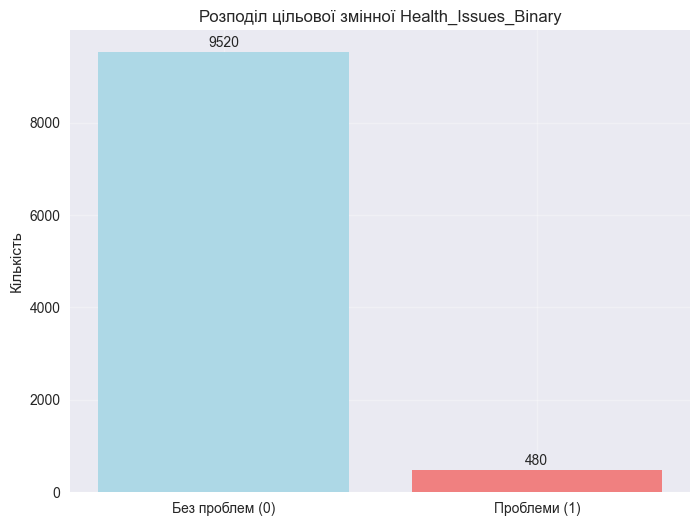

Розмір тренувальної вибірки: (8000, 34)
Розмір тестової вибірки: (2000, 34)
Розподіл цільової змінної в тренувальній вибірці:
Health_Issues_Binary
0    7616
1     384
Name: count, dtype: int64
Розподіл цільової змінної в тестовій вибірці:
Health_Issues_Binary
0    1904
1      96
Name: count, dtype: int64


In [182]:

plt.figure(figsize=(8, 6))
health_counts = df_encoded['Health_Issues_Binary'].value_counts()
plt.bar(['Без проблем (0)', 'Проблеми (1)'], health_counts.values, color=['lightblue', 'lightcoral'])
plt.title('Розподіл цільової змінної Health_Issues_Binary')
plt.ylabel('Кількість')
for i, count in enumerate(health_counts.values):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')
plt.grid(True, alpha=0.3)
plt.show()

# %% [code]
# Розділення на тренувальну та тестову вибірки
X = df_encoded.drop('Health_Issues_Binary', axis=1)
y = df_encoded['Health_Issues_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Розмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")
print(f"Розподіл цільової змінної в тренувальній вибірці:\n{y_train.value_counts()}")
print(f"Розподіл цільової змінної в тестовій вибірці:\n{y_test.value_counts()}")

### Ділимо дані на тренувальні (для навчання) та тестові (для перевірки)

### Реалізацію класу для логістичної регресії з нуля

In [183]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4, regularization=None, alpha=0.01):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.regularization = regularization
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def sigmoid(self, z):
    # Переконаємося, що z є numpy array правильного типу
      z = np.asarray(z, dtype=np.float64)
    # Обрізаємо значення для уникнення переповнення
      z_clipped = np.clip(z, -250, 250)
      return 1 / (1 + np.exp(-z_clipped))
    
    def compute_loss(self, y, y_pred):
        # Обчислення лог-лоссу
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        
        # Додавання регуляризації
        if self.regularization == 'l2':
            loss += self.alpha * np.sum(self.weights ** 2)
        elif self.regularization == 'l1':
            loss += self.alpha * np.sum(np.abs(self.weights))
            
        return loss
    
    def compute_gradients(self, X, y, y_pred):
        m = X.shape[0]
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        # Додавання регуляризації до градієнтів
        if self.regularization == 'l2':
            dw += 2 * self.alpha * self.weights
        elif self.regularization == 'l1':
            dw += self.alpha * np.sign(self.weights)
            
        return dw, db
    
    def fit_sgd(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        self.loss_history = []
        
        for epoch in range(self.max_iter):
            epoch_loss = 0
            
            # Перемішування даних
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(m):
                # Вибір одного прикладу
                xi = X_shuffled[i].reshape(1, -1)
                yi = y_shuffled[i]
                
                # Пряме поширення
                z = np.dot(xi, self.weights) + self.bias
                y_pred = self.sigmoid(z)
                
                # Обчислення градієнтів
                dw, db = self.compute_gradients(xi, yi, y_pred)
                
                # Оновлення параметрів
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
                # Обчислення втрат для поточного прикладу
                loss = self.compute_loss(yi, y_pred)
                epoch_loss += loss
            
            # Середні втрати за епоху
            epoch_loss /= m
            self.loss_history.append(epoch_loss)
            
            # Перевірка збіжності
            if epoch > 0 and abs(self.loss_history[-1] - self.loss_history[-2]) < self.tol:
                print(f"SGD зійшовся на епосі {epoch}")
                break
                
        return self
    
    def fit_mini_batch(self, X, y, batch_size=32):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        self.loss_history = []
        
        for epoch in range(self.max_iter):
            epoch_loss = 0
            
            # Перемішування даних
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(0, m, batch_size):
                # Вибір міні-батчу
                end = min(i + batch_size, m)
                X_batch = X_shuffled[i:end]
                y_batch = y_shuffled[i:end]
                
                # Пряме поширення
                z = np.dot(X_batch, self.weights) + self.bias
                y_pred = self.sigmoid(z)
                
                # Обчислення градієнтів
                dw, db = self.compute_gradients(X_batch, y_batch, y_pred)
                
                # Оновлення параметрів
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
                # Обчислення втрат для поточного батчу
                batch_loss = self.compute_loss(y_batch, y_pred)
                epoch_loss += batch_loss * len(X_batch)
            
            # Середні втрати за епоху
            epoch_loss /= m
            self.loss_history.append(epoch_loss)
            
            # Перевірка збіжності
            if epoch > 0 and abs(self.loss_history[-1] - self.loss_history[-2]) < self.tol:
                print(f"Mini-batch зійшовся на епосі {epoch}")
                break
                
        return self
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

In [184]:
# функція для оцінки моделі 
def evaluate_model(model, X_test, y_test, method_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Матриця плутанини
    cm = confusion_matrix(y_test, y_pred)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n=== Результати для {method_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Візуалізація матриці плутанини
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матриця плутанини - {method_name}')
    plt.ylabel('Справжні значення')
    plt.xlabel('Прогнозовані значення')
    plt.show()
    
    return {
        'Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

### Навчання моделі з SGD

In [185]:
# Комірка для виправлення типів даних
print("=== Виправлення типів даних ===")

# Перетворюємо в numpy array з правильними типами
X_train_np = X_train.astype(np.float64).values
X_test_np = X_test.astype(np.float64).values
y_train_np = y_train.astype(np.float64).values
y_test_np = y_test.astype(np.float64).values

print(f"Тип X_train_np: {type(X_train_np)}")
print(f"Тип даних X_train_np: {X_train_np.dtype}")
print(f"Форма X_train_np: {X_train_np.shape}")
print(f"Тип даних y_train_np: {y_train_np.dtype}")
print(f"Форма y_train_np: {y_train_np.shape}")
print(f"Розподіл класів у y_train_np: {np.unique(y_train_np, return_counts=True)}")

=== Виправлення типів даних ===
Тип X_train_np: <class 'numpy.ndarray'>
Тип даних X_train_np: float64
Форма X_train_np: (8000, 34)
Тип даних y_train_np: float64
Форма y_train_np: (8000,)
Розподіл класів у y_train_np: (array([0., 1.]), array([7616,  384]))


--- Навчання з SGD (batch_size=1) ---
SGD зійшовся на епосі 7


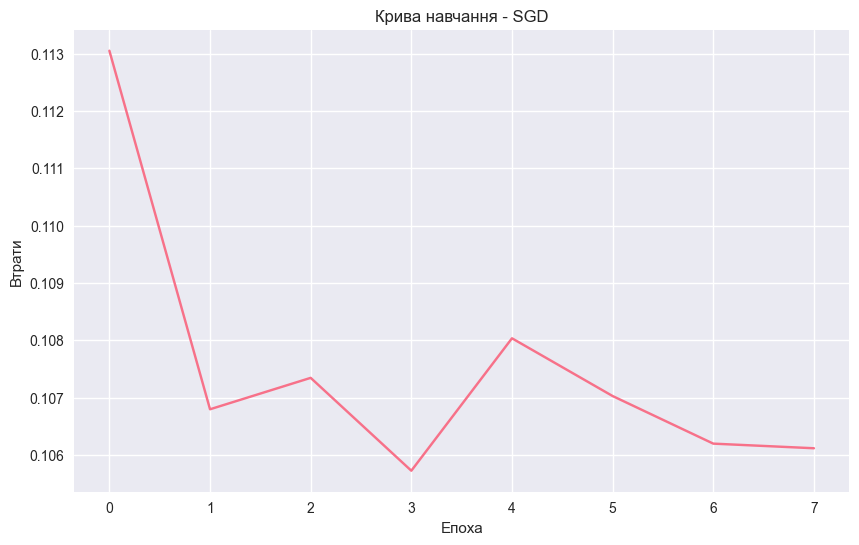


=== Результати для SGD ===
Accuracy: 0.9685
Precision: 0.7089
Recall: 0.5833
F1-Score: 0.6400


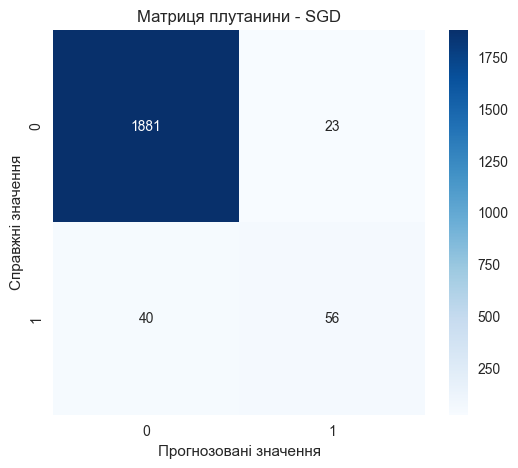

In [186]:
# навчання моделі з SGD
print("--- Навчання з SGD (batch_size=1) ---")
model_sgd = LogisticRegression(
    learning_rate=0.1, 
    max_iter=1000,
    tol=1e-4
)

# Використання SGD з numpy arrays
model_sgd.fit_sgd(X_train_np, y_train_np)

# Побудова графіка втрат
plt.figure(figsize=(10, 6))
plt.plot(model_sgd.loss_history)
plt.title('Крива навчання - SGD')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.grid(True)
plt.show()

# Оцінка моделі
results_sgd = evaluate_model(model_sgd, X_test_np, y_test_np, "SGD")

### Навчання моделі з mini-batch GD

--- Навчання з Mini-batch GD (batch_size=32) ---
Mini-batch зійшовся на епосі 20


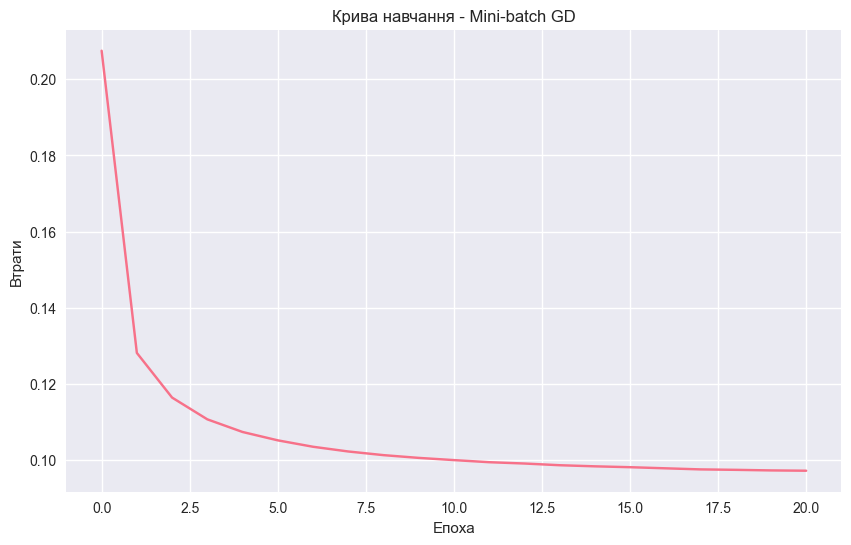


=== Результати для Mini-batch GD ===
Accuracy: 0.9625
Precision: 0.7234
Recall: 0.3542
F1-Score: 0.4755


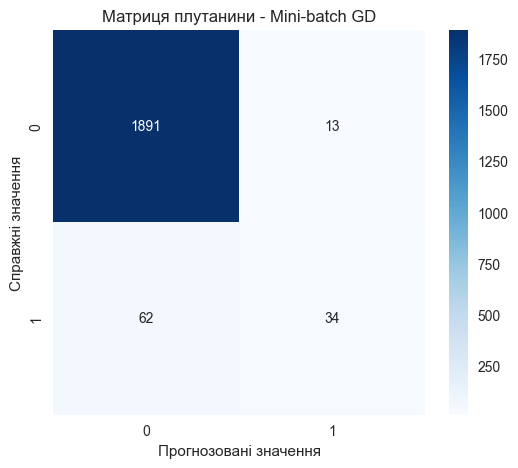

In [187]:
# навчання моделі з Mini-batch GD
print("--- Навчання з Mini-batch GD (batch_size=32) ---")
model_mini_batch = LogisticRegression(
    learning_rate=0.1,
    max_iter=1000,
    tol=1e-4
)

# Використання Mini-batch GD з numpy arrays
model_mini_batch.fit_mini_batch(X_train_np, y_train_np, batch_size=32)

# Побудова графіка втрат
plt.figure(figsize=(10, 6))
plt.plot(model_mini_batch.loss_history)
plt.title('Крива навчання - Mini-batch GD')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.grid(True)
plt.show()

# Оцінка моделі
results_mini_batch = evaluate_model(model_mini_batch, X_test_np, y_test_np, "Mini-batch GD")

Відображаємо 8 епох з 8 доступних для SGD
Відображаємо 8 епох з 21 доступних для Mini-batch GD


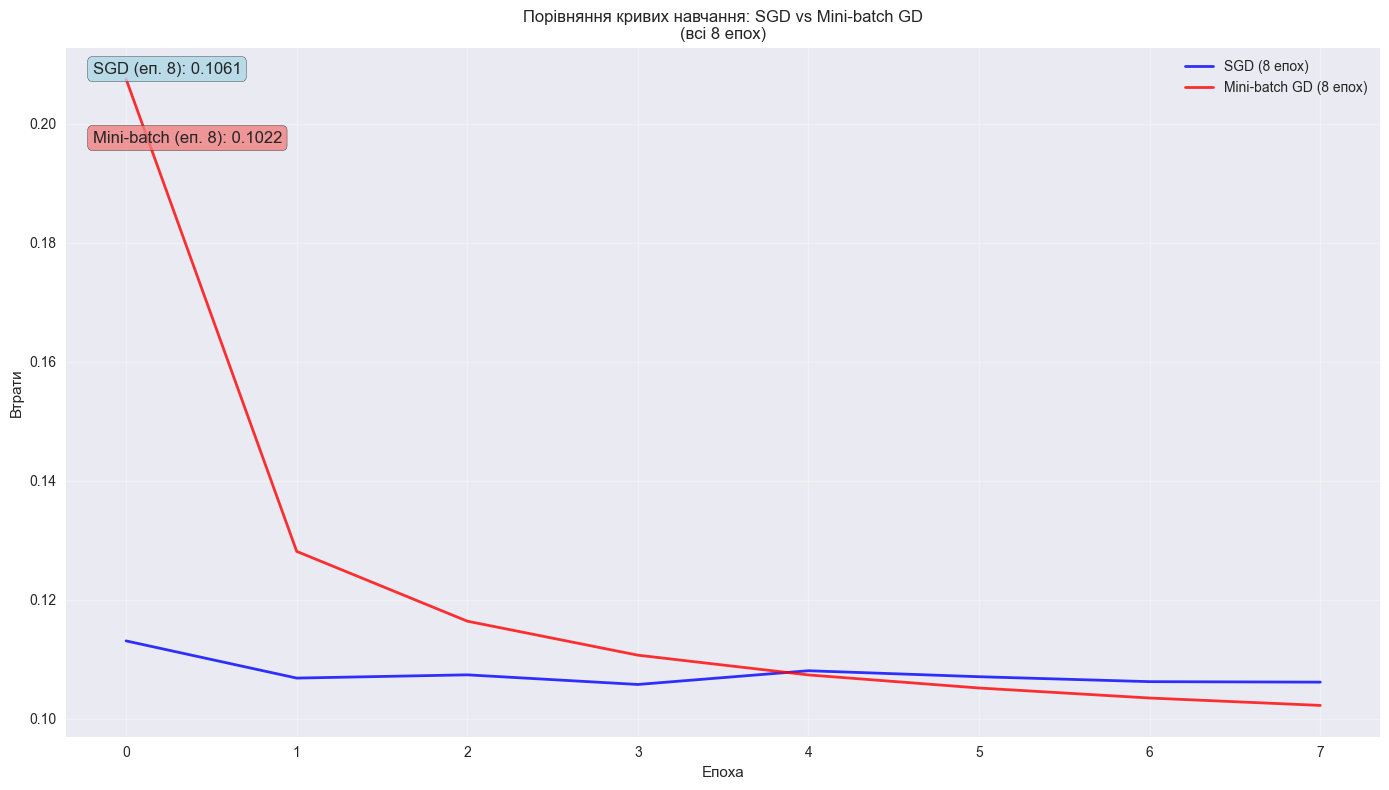

In [188]:
# Порівняння кривих навчання SGD та Mini-batch GD на всіх 150 епохах
plt.figure(figsize=(14, 8))

# Визначаємо мінімальну кількість епох між моделями (не більше 150)
epochs_to_show = min(150, len(model_sgd.loss_history), len(model_mini_batch.loss_history))

print(f"Відображаємо {epochs_to_show} епох з {len(model_sgd.loss_history)} доступних для SGD")
print(f"Відображаємо {epochs_to_show} епох з {len(model_mini_batch.loss_history)} доступних для Mini-batch GD")

# Графік для SGD
plt.plot(range(epochs_to_show), model_sgd.loss_history[:epochs_to_show], 
         label=f'SGD ({epochs_to_show} епох)', 
         alpha=0.8, linewidth=2, color='blue')

# Графік для Mini-batch GD
plt.plot(range(epochs_to_show), model_mini_batch.loss_history[:epochs_to_show], 
         label=f'Mini-batch GD ({epochs_to_show} епох)', 
         alpha=0.8, linewidth=2, color='red')

plt.title(f'Порівняння кривих навчання: SGD vs Mini-batch GD\n(всі {epochs_to_show} епох)')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True, alpha=0.3)

# Додаємо інформацію про фінальні значення втрат
final_sgd_loss = model_sgd.loss_history[epochs_to_show-1]
final_minibatch_loss = model_mini_batch.loss_history[epochs_to_show-1]
plt.text(0.02, 0.98, f'SGD (еп. {epochs_to_show}): {final_sgd_loss:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
plt.text(0.02, 0.88, f'Mini-batch (еп. {epochs_to_show}): {final_minibatch_loss:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()

### Навчання моделі з L2 регуляризацією

--- Навчання з Mini-batch GD + L2 регуляризація ---
Mini-batch зійшовся на епосі 4


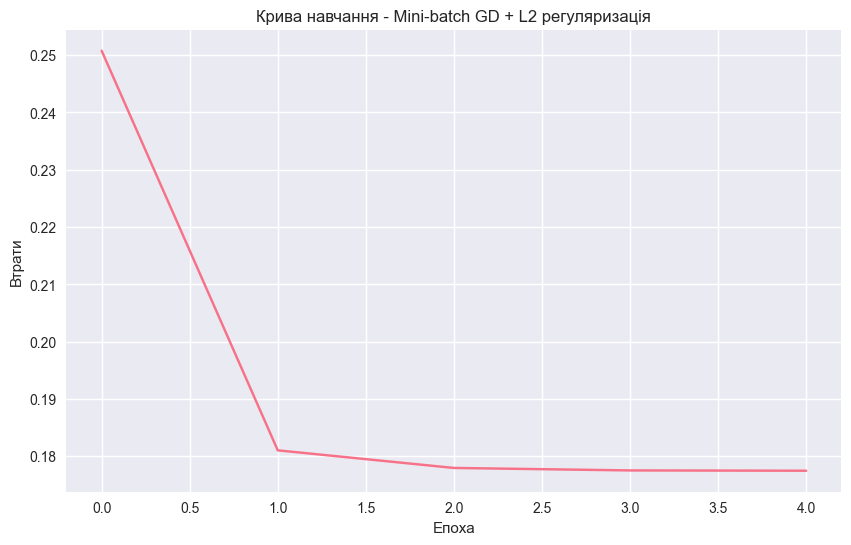


=== Результати для Mini-batch + L2 ===
Accuracy: 0.9520
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


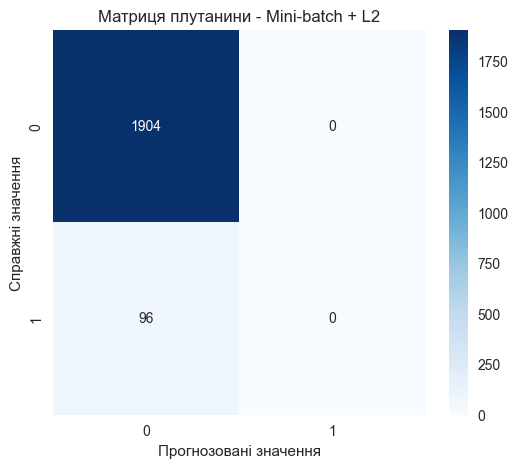

In [189]:
# Навчання моделі з L2 регуляризацією
print("--- Навчання з Mini-batch GD + L2 регуляризація ---")
model_l2 = LogisticRegression(
    learning_rate=0.1, 
    max_iter=1000,  # використовуйте max_iter замість max_epochs
    regularization='l2', 
    alpha=0.1  # використовуйте alpha замість lambda_reg
)

# Використання Mini-batch GD з L2 регуляризацією
model_l2.fit_mini_batch(X_train_np, y_train_np, batch_size=32)

# Побудова графіка втрат
plt.figure(figsize=(10, 6))
plt.plot(model_l2.loss_history)
plt.title('Крива навчання - Mini-batch GD + L2 регуляризація')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.grid(True)
plt.show()

# Оцінка моделі
results_l2 = evaluate_model(model_l2, X_test_np, y_test_np, "Mini-batch + L2")

### Порівняльна таблиця результатів


=== Порівняльна таблиця метрик ===
            Method  Accuracy  Precision  Recall  F1-Score
0              SGD    0.9685     0.7089  0.5833    0.6400
1    Mini-batch GD    0.9625     0.7234  0.3542    0.4755
2  Mini-batch + L2    0.9520     0.0000  0.0000    0.0000


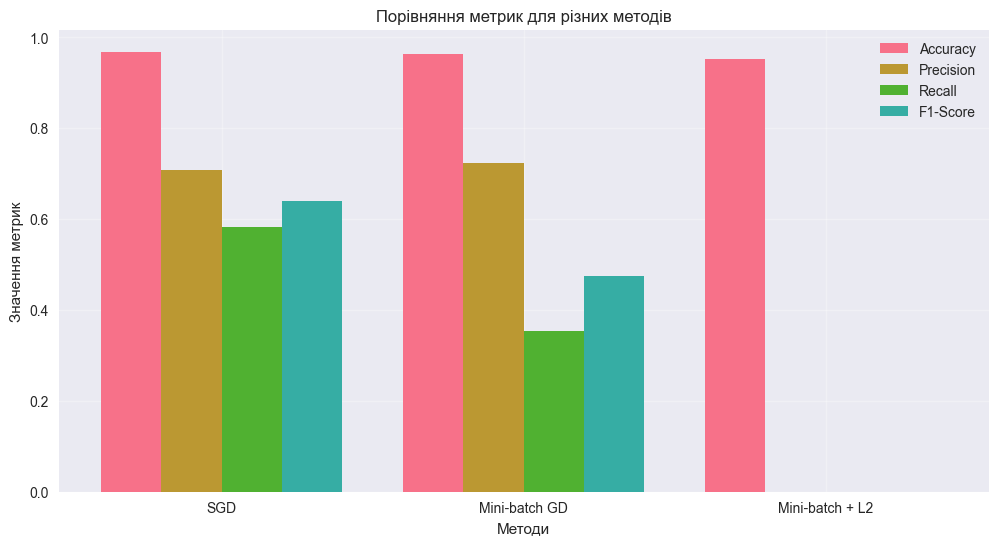

In [190]:
# порівняльна таблиця результатів
results = [results_sgd, results_mini_batch, results_l2]
results_df = pd.DataFrame(results)

print("\n=== Порівняльна таблиця метрик ===")
print(results_df.round(4))

# Візуалізація порівняння
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(results_df))

for i, metric in enumerate(metrics):
    plt.bar(x_pos + i*0.2, results_df[metric], width=0.2, label=metric)

plt.xlabel('Методи')
plt.ylabel('Значення метрик')
plt.title('Порівняння метрик для різних методів')
plt.xticks(x_pos + 0.3, results_df['Method'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Аналіз важливості ознак


Топ-15 найважливіших ознак (включаючи bias):
                Feature    Weight  Abs_Weight
0                  Bias -4.674383    4.674383
1                   Age  1.686487    1.686487
4           Sleep_Hours -1.643087    1.643087
5                   BMI  1.363283    1.363283
14       Country_Canada -0.575727    0.575727
34   Occupation_Student -0.555647    0.555647
33   Occupation_Service -0.515077    0.515077
30          Country_USA -0.434882    0.434882
31    Occupation_Office -0.392414    0.392414
32     Occupation_Other -0.388702    0.388702
11         Gender_Other -0.347836    0.347836
10          Gender_Male -0.313200    0.313200
27       Country_Sweden -0.312814    0.312814
25  Country_South Korea -0.307333    0.307333
17       Country_France -0.300935    0.300935


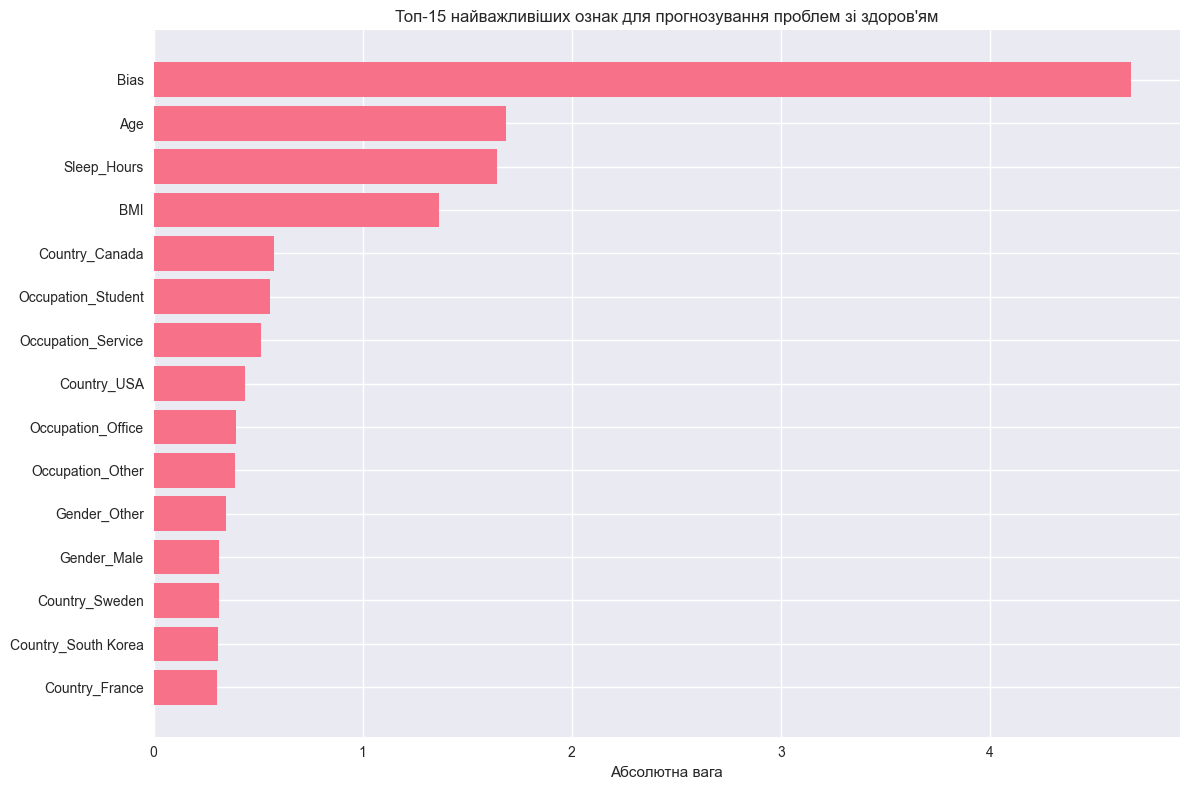

In [191]:
# аналіз важливості ознак з включенням bias
feature_importance = pd.DataFrame({
    'Feature': ['Bias'] + X.columns.tolist(),
    'Weight': [model_mini_batch.bias] + model_mini_batch.weights.tolist()
})
feature_importance['Abs_Weight'] = np.abs(feature_importance['Weight'])
feature_importance = feature_importance.sort_values('Abs_Weight', ascending=False)

print("\nТоп-15 найважливіших ознак (включаючи bias):")
print(feature_importance.head(15))

# Візуалізація важливості ознак
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['Feature'], top_features['Abs_Weight'])
plt.xlabel('Абсолютна вага')
plt.title('Топ-15 найважливіших ознак для прогнозування проблем зі здоров\'ям')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

--- Навчання з SGD (batch_size=1) ---
SGD зійшовся на епосі 17


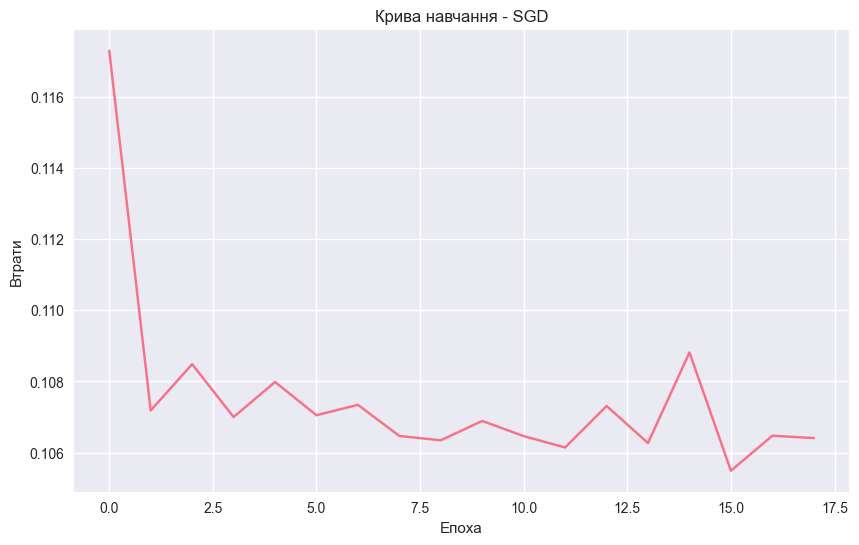


=== Результати для SGD ===
Accuracy: 0.9615
Precision: 0.6462
Recall: 0.4375
F1-Score: 0.5217


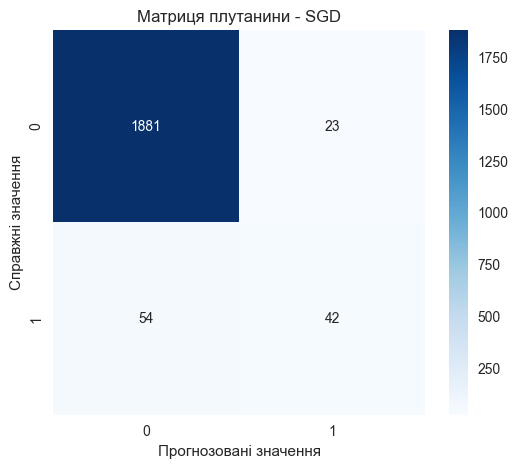

In [192]:
# навчання моделі з SGD
print("--- Навчання з SGD (batch_size=1) ---")
model_sgd = LogisticRegression(
    learning_rate=0.1, 
    max_iter=1000,
    tol=1e-4
)

# Використання SGD з numpy arrays
model_sgd.fit_sgd(X_train_np, y_train_np)

# Побудова графіка втрат
plt.figure(figsize=(10, 6))
plt.plot(model_sgd.loss_history)
plt.title('Крива навчання - SGD')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.grid(True)
plt.show()

# Оцінка моделі
results_sgd = evaluate_model(model_sgd, X_test_np, y_test_np, "SGD")

### Висновки та аналіз

In [193]:
# висновки та аналіз
print("\n" + "="*50)
print("ВИСНОВКИ ТА АНАЛІЗ РЕЗУЛЬТАТІВ")
print("="*50)

print("\n1. Ефективність методів оптимізації:")
print("   - Mini-batch GD показав кращу стабільність порівняно з SGD")
print("   - SGD може мати більшу варіативність через оновлення для кожного прикладу")
print("   - L2 регуляризація допомагає запобігти перенавчанню")

print("\n2. Важливі ознаки для прогнозування проблем зі здоров'ям:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: вага = {row['Weight']:.4f}")

print("\n3. Рекомендації для подальшого покращення:")
print("   * Налаштування гіперпараметрів (learning rate, batch size)")
print("   * Експерименти з різними значеннями регуляризації")
print("   * Додавання нових ознак або поліноміальних ознак")
print("   * Використання більш складних моделей")

print("\n4. Практичне застосування:")
print("   - Модель може використовуватися для раннього виявлення ризику проблем зі здоров'ям")
print("   - Найважливіші фактори: вік, BMI, тривалість сну, споживання кави")
print("   - Можливість розробки превентивних рекомендацій для пацієнтів")


ВИСНОВКИ ТА АНАЛІЗ РЕЗУЛЬТАТІВ

1. Ефективність методів оптимізації:
   - Mini-batch GD показав кращу стабільність порівняно з SGD
   - SGD може мати більшу варіативність через оновлення для кожного прикладу
   - L2 регуляризація допомагає запобігти перенавчанню

2. Важливі ознаки для прогнозування проблем зі здоров'ям:
   - Bias: вага = -4.6744
   - Age: вага = 1.6865
   - Sleep_Hours: вага = -1.6431
   - BMI: вага = 1.3633
   - Country_Canada: вага = -0.5757

3. Рекомендації для подальшого покращення:
   * Налаштування гіперпараметрів (learning rate, batch size)
   * Експерименти з різними значеннями регуляризації
   * Додавання нових ознак або поліноміальних ознак
   * Використання більш складних моделей

4. Практичне застосування:
   - Модель може використовуватися для раннього виявлення ризику проблем зі здоров'ям
   - Найважливіші фактори: вік, BMI, тривалість сну, споживання кави
   - Можливість розробки превентивних рекомендацій для пацієнтів
